# Clasificación de FashionMNIST con red neuronal convolucional CNN

**Nota:** Esta es una adaptación de un colab cortesía de Nahuel Almeira.

## Importando librerías

Importamos librerías, configuramos los gráficos, etc.

In [ ]:
import numpy as np
from tqdm.notebook import tqdm              ## Barras de progreso

import pickle                               ## Para guardar en y leer de archivos, objetos de Python

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from torchvision import datasets

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

## Configuración general
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

Vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Cargamos el dataset

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.

In [ ]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [ ]:
batch_size = 64

## Creamos los data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Creamos el modelo

In [ ]:
## Definimos el segundo modelo
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        ## Primera capa convolucional: construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=32,            
                kernel_size=3,                                 
                padding=1,                  
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),
            ## Aplicamos la función de activación               
            nn.ReLU(),    
            ## Reducimos la imagen con Max Pooling                  
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )

        ## Segunda capa convolucional: construimos 64 canales usando filtros (kernels) de 3x3
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,                               
                padding=0
            ),    
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),                
        )

        ## "Achatamos" la salida de la última capa, de 64 canales de tamaño 6x6, transformándola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales agregamos algunas capas densas. La última (de 10 neuronas) es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 300),
            nn.Dropout(0.25), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(150, 10),
            nn.Dropout(0.25),
            nn.ReLU() 
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)     
        x = self.linear_relu_stack(x)
        return x

## Creamos una instancia de nuestro modelo (un objeto de la clase correspondiente)

model = CNN()
model_name = "CNN" # Convolutional Neuronal Network

## "enviamos" el modelo a la GPU o a la CPU según esté disponible
model.to(device)

print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=300, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=150, bias=True)
    (4): Dropout(p=0.25, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=150, out_features=10, bias=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Re

## Entrenamiento del modelo

In [ ]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

#loss_fn = nn.BCELoss()                                                           # VER SI PONEMOS ESTA PERDIDA TAMBIEN O NO!!!!
#loss_fn_name = 'BinaryCrossEntropy'

## Definimos el optimizador:
learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

optimizer = adam_optimizer

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.

In [ ]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [ ]:
epochs = 15
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(train_dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1
loss: 0.035968  [    0/60000]
loss: 0.021531  [ 6400/60000]
loss: 0.017590  [12800/60000]
loss: 0.018338  [19200/60000]
loss: 0.020027  [25600/60000]
loss: 0.017455  [32000/60000]
loss: 0.020666  [38400/60000]
loss: 0.016126  [44800/60000]
loss: 0.019000  [51200/60000]
loss: 0.021858  [57600/60000]

Train performance:
Accuracy: 78.02%, Avg loss: 0.010213
Test performance:
Accuracy: 76.89%, Avg loss: 0.010739
-------------------------------------

Época 2
loss: 0.015655  [    0/60000]
loss: 0.015070  [ 6400/60000]
loss: 0.016126  [12800/60000]
loss: 0.012675  [19200/60000]
loss: 0.010328  [25600/60000]
loss: 0.013973  [32000/60000]
loss: 0.010554  [38400/60000]
loss: 0.018181  [44800/60000]
loss: 0.014177  [51200/60000]
loss: 0.013149  [57600/60000]

Train performance:
Accuracy: 89.87%, Avg loss: 0.005772
Test performance:
Accuracy: 88.63%, Avg loss: 0.006407
-------------------------------------

Época 3
loss: 0.011109  [    0/60000]
loss: 0.014890  [ 6400/60000]
loss: 0.011718

## Observamos las predicciones

In [ ]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.savefig('ejemplo-120.pdf', dpi=600, format='pdf')   ## Graficamos la imagen del input 120
    plt.show()

def show_prediction(example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}', 
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

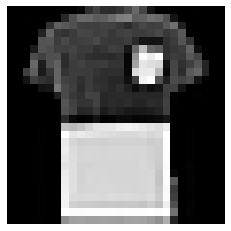

Etiqueta correcta: T-Shirt
----------------
Etiqueta     Probabilidad
T-Shirt      1.00000
Ankle Boot   0.00000
Dress        0.00000
Bag          0.00000
Trouser      0.00000
Pullover     0.00000
Sandal       0.00000
Coat         0.00000
Shirt        0.00000
Sneaker      0.00000


In [ ]:
example = 120
plot_img(test_data, example)
show_prediction(example)

## Graficamos los resultados

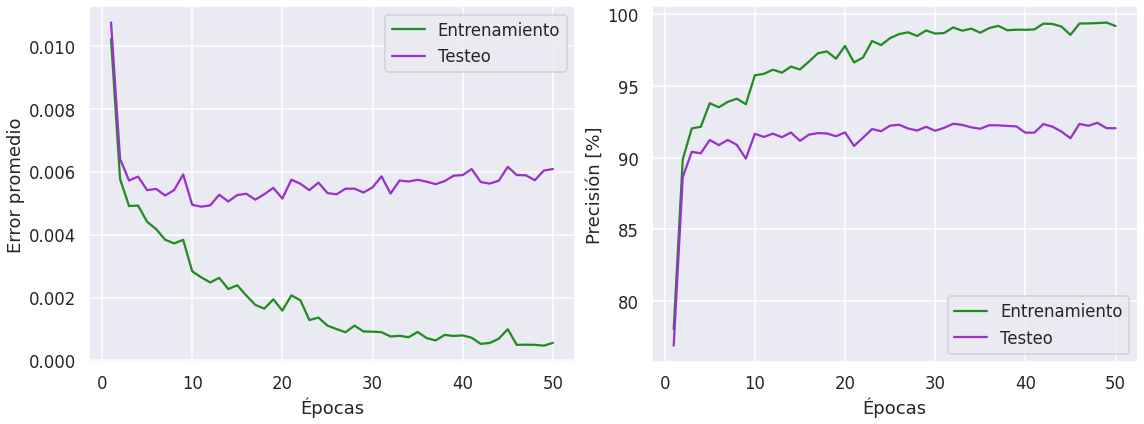

In [ ]:
X = range(1, len(train_losses)+1)

fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
ax = axes[0]
ax.set_xlabel('Épocas')
ax.set_ylabel('Error promedio')
ax.plot(X, train_losses, label='Entrenamiento', c='forestgreen')
ax.plot(X, test_losses, label='Testeo', c='darkorchid')
ax.legend()

ax = axes[1]
ax.set_xlabel('Épocas')
ax.set_ylabel('Precisión [%]')
ax.plot(X, train_acc_values, label='Entrenamiento', c='forestgreen')
ax.plot(X, test_acc_values, label='Testeo', c='darkorchid')
ax.legend()

fig.tight_layout()
plt.savefig('CNN-15_epocas.pdf', dpi=600, format='pdf')
plt.show()

## Guardamos en un archivo de texto los resultados

(Para poder usarlos en el ipynb "ANN y comparación con CNN")

In [ ]:
e_train_CNN = train_losses
e_test_CNN = test_losses
ac_train_CNN = train_acc_values
ac_test_CNN = test_acc_values

In [ ]:
stack = np.vstack([e_train_CNN, e_test_CNN, ac_train_CNN, ac_test_CNN])
np.savetxt('data_CNN', stack)